<a href="https://colab.research.google.com/github/NishantJethwa/Image-Captioning/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

keras = tf.keras

from nltk.translate.bleu_score import corpus_bleu

In [ ]:
max_cap_len = 15  # Determines max length of captioning sentences
img_dimension = 299 # Determines the height and width of images
num_words = 10000 # Determines vocab size to tokenize and train on
encoding_size = 512 # Determines dimension of the encodings of images
LSTM_size = 512 
batch_size = 128
n_epochs = 15
Buffer_size = 1000
validation_and_test_split = 0.4
test_to_val_split = 0.8
#num_examples = None 

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'

annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
PATH = os.path.dirname(image_zip) + image_folder
os.remove(image_zip)

13510574080/13510573713 [==============================] - 328s 0us/step


In [ ]:
PATH = '/content/train2014/'
annotation_file = '/content/annotations/captions_train2014.json'

In [ ]:
# Read the json file
#annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = annot['caption']
    
    caption = caption.replace(" a "," ")
    caption = caption.replace("A ","")    
    caption = caption.replace("An ","")
    caption = caption.replace(" an "," ")    
    caption = caption.replace(" the "," ")
    caption = caption.replace("The ","")

    #Load only captions that don't exceed maximum length
    if len(caption.split(" ")) > max_cap_len:
      continue
    else:
      caption = '<sos> ' + caption + ' <eos>'
      image_id = annot['image_id']
      full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

      all_img_name_vector.append(full_coco_image_path)
      all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=42)

# train_captions = train_captions[:num_examples]
# img_name_vector = img_name_vector[:num_examples]

train_captions = train_captions[:]
img_name_vector = img_name_vector[:]

caption_train, captions_test, img_name_vector_train, img_name_vector_test = train_test_split(train_captions,
                                                                      img_name_vector,
                                                                      test_size= validation_and_test_split)

caption_val, caption_test, img_name_vector_val, img_name_vector_test = train_test_split(captions_test,
                                                        img_name_vector_test,
                                                        test_size= test_to_val_split)
num_samples = len(img_name_vector)
assert len(train_captions) == len(img_name_vector)
print("Loaded %d samples" %(num_samples))
print("Loaded %d train samples" %(len(caption_train)))
print("------------")
print("Loaded %d valid samples" %(len(caption_val)))
print("img_name_vector_val: ",len(img_name_vector_val))
print("------------")
print("Loaded %d test samples" %(len(caption_test)))
print("img_name_vector_test: ",len(img_name_vector_test))

Loaded 409297 samples
Loaded 245578 train samples
------------
Loaded 32743 valid samples
img_name_vector_val:  32743
------------
Loaded 130976 test samples
img_name_vector_test:  130976


In [ ]:
caption_val2, caption_test2, img_name_vector_val2, img_name_vector_test2 = train_test_split(caption_val,
                                                        img_name_vector_val,
                                                        test_size= 0.035)

print("Loaded %d valid samples" %(len(caption_val2)))
print("img_name_vector_val: ",len(img_name_vector_val2))


Loaded 31596 valid samples
img_name_vector_val:  31596


In [ ]:
# caption_val4, caption_test4, img_name_vector_val4, img_name_vector_test4 = train_test_split(caption_val3,
#                                                         img_name_vector_val3,
#                                                         test_size= 0.5)

# print("Loaded %d valid samples" %(len(caption_val4)))
# print("img_name_vector_val: ",len(img_name_vector_val4))


In [ ]:
print(PATH)
print(annotation_file)

/content/train2014/
/content/annotations/captions_train2014.json


In [ ]:
tok = keras.preprocessing.text.Tokenizer(num_words = num_words
                                         ,filters ="!?,'()_-+=&*$#@.",oov_token="<unk>") # oov - out of vocab
tok.fit_on_texts(caption_train)
captions_train = tok.texts_to_sequences(caption_train)

if num_words == None:
  words = len(tok.word_index)
else:
  words = num_words

captions_train = keras.preprocessing.sequence.pad_sequences(captions_train, padding='post',maxlen=max_cap_len + 2)
print("Examlpe:", captions_train[np.random.randint(low=0, high= len(captions_train) - 1,size=1)[0]])
print("Found %d unique words" %(words))

Examlpe: [   2   14  442    7  343 1539    8  270    8   20  100    3    0    0
    0    0    0]
Found 10000 unique words


In [ ]:
captions_valid = tok.texts_to_sequences(caption_val)
captions_valid = keras.preprocessing.sequence.pad_sequences(captions_valid, padding='post',maxlen=max_cap_len + 2)

In [ ]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (img_dimension, img_dimension))
  return img

In [ ]:
def preprocess_func(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_train,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [ ]:
def preprocess_func_val(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_val,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]

  h_and_c_init = tf.zeros((LSTM_size))
  
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [ ]:
#Creating an array to index each img path for reading 
path_index_vec_train = np.array(list(range(0,len(img_name_vector_train)))).reshape(-1,1)
path_index_vec_val = np.array(list(range(0,len(img_name_vector_val)))).reshape(-1,1)

dataset1_train = tf.data.Dataset.from_tensor_slices(path_index_vec_train)
dataset2_train = tf.data.Dataset.from_tensor_slices(captions_train)
dataset = tf.data.Dataset.zip((dataset1_train,dataset2_train))
dataset = dataset.map(preprocess_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset1_val = tf.data.Dataset.from_tensor_slices(path_index_vec_val)
dataset2_val = tf.data.Dataset.from_tensor_slices(captions_valid)
dataset_val = tf.data.Dataset.zip((dataset1_val,dataset2_val))
dataset_val = dataset_val.map(preprocess_func_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
dataset = dataset.shuffle(Buffer_size).batch(batch_size,drop_remainder=True).prefetch(1)
dataset_val = dataset_val.shuffle(Buffer_size).batch(256,drop_remainder=True).prefetch(1)

In [ ]:
from keras.applications.inception_v3 import preprocess_input


incep = keras.applications.inception_v3.InceptionV3(input_shape=(img_dimension,img_dimension,3),
                                                    include_top=False)
incep.trainable=False
#incep.summary()

In [ ]:
encoder = keras.models.Sequential([
                                   keras.layers.Lambda(preprocess_input,input_shape=(img_dimension,img_dimension,3),name="preprocessing_layer"),
                                   incep,
                                   keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer"),
                                   keras.layers.Reshape((8*8,encoding_size),name="reshape_layer")
                                  ],name="Encoder")
#encoder.summary()

In [ ]:
W1 = keras.layers.Dense(512,name="W1")
W2 = keras.layers.Dense(512,name="W2")
V = keras.layers.Dense(1,name="V")
repeater = keras.layers.RepeatVector(8*8)
doter = keras.layers.Dot(axes=1)
concatenator = keras.layers.Concatenate()

def attention_step(enc,h_prev):
  h = repeater(h_prev)
  score = tf.nn.tanh(W1(enc)+ W2(h))

  alphas =tf.nn.softmax(V(score),axis=1)

  context = doter([alphas,enc])
  return context

In [ ]:
encodings = keras.layers.Input(shape=(8*8,encoding_size))

init_h = keras.layers.Input(shape=(LSTM_size))
init_c = keras.layers.Input(shape=(LSTM_size))

teacher_forcing = keras.layers.Input(shape=(1))

embedding_layer = keras.layers.Embedding(words+1,256,)


context_prev_tar_concat_layer = keras.layers.Concatenate()
decoder_lstm_layer = keras.layers.LSTM(LSTM_size,return_state=True,dropout=0.2)
decoder_dense_layer = keras.layers.Dense(words+1,activation='softmax')

h = init_h

c = init_c

context = attention_step(encodings,h)

embedds = embedding_layer(teacher_forcing)

decoder_lstm_input = context_prev_tar_concat_layer([context,embedds])
  
h , _ , c = decoder_lstm_layer(decoder_lstm_input,initial_state=[h,c])
  
out = decoder_dense_layer(h)

decoder = keras.models.Model([encodings,init_h,init_c,teacher_forcing],[out,h,c])
#decoder.summary()

In [ ]:
def sparse_it_up(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  real = tf.cast(real,tf.int64)
  real = tf.one_hot(real,words+1,axis=-1)

  loss_ = tf.losses.categorical_crossentropy(real, pred)

  mask = tf.cast(mask, dtype=tf.float32)

  loss_ *= mask

  return tf.reduce_mean(loss_)


In [ ]:
optimizer = keras.optimizers.Adam()

@tf.function
def train_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [ ]:
'''This function is for forward passing features for calculating losses with no backprop'''
@tf.function
def valid_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  return loss

In [ ]:
import numpy as np
EPOCHS = 5
prev_loss = np.inf
batch_loss_array = []
val_loss_array = []

import time

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, ((img, s, teacher) ,target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img, s, teacher ,target)        
        total_loss += t_loss

        if batch % 100 == 0:
            batch_loss_array.append(batch_loss.numpy()/int(target.shape[1]))
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    val_loss=0

    for (i, ((img, s, teacher) ,target)) in enumerate(dataset_val):
      val_loss += valid_step(img, s, teacher ,target)
    
    val_loss = val_loss.numpy()/((i+1)*(max_cap_len+1))
    val_loss_array.append(val_loss)
    print("val_loss=",val_loss)
    
    #This code makes sure we only save the best val_loss score weights
    if val_loss < prev_loss:
      print("Model_imporved. Saving..")

      encoder.save("/content/drive/MyDrive/COCO/parth/assets/encoder.h5")
      decoder.save("/content/drive/MyDrive/COCO/parth/assets/decoder.h5")
    
    else:
      print("Model didn't imporve.")

    prev_loss = val_loss

Epoch 1 Batch 0 Loss 5.5094
Epoch 1 Batch 100 Loss 3.3971
Epoch 1 Batch 200 Loss 3.2203
Epoch 1 Batch 300 Loss 2.9129
Epoch 1 Batch 400 Loss 2.5240
Epoch 1 Batch 500 Loss 2.3955
Epoch 1 Batch 600 Loss 2.3483
Epoch 1 Batch 700 Loss 2.1244
Epoch 1 Batch 800 Loss 2.2305
Epoch 1 Batch 900 Loss 2.1822
Epoch 1 Batch 1000 Loss 2.0226
Epoch 1 Batch 1100 Loss 2.0848
Epoch 1 Batch 1200 Loss 1.8186
Epoch 1 Batch 1300 Loss 1.9820
Epoch 1 Batch 1400 Loss 2.0504
Epoch 1 Batch 1500 Loss 1.9461
Epoch 1 Batch 1600 Loss 1.9129
Epoch 1 Batch 1700 Loss 1.9519
Epoch 1 Batch 1800 Loss 1.8150
Epoch 1 Batch 1900 Loss 1.8240
val_loss= 1.8673591914139396
Model_imporved. Saving..
Epoch 2 Batch 0 Loss 1.8694
Epoch 2 Batch 100 Loss 1.8229
Epoch 2 Batch 200 Loss 1.6041
Epoch 2 Batch 300 Loss 2.0133
Epoch 2 Batch 400 Loss 1.7874
Epoch 2 Batch 500 Loss 1.9499
Epoch 2 Batch 600 Loss 1.8145
Epoch 2 Batch 700 Loss 1.7768
Epoch 2 Batch 800 Loss 1.7517
Epoch 2 Batch 900 Loss 1.7528
Epoch 2 Batch 1000 Loss 1.7069
Epoch 2 B

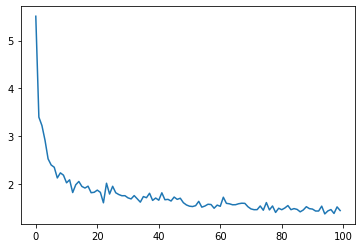

In [ ]:
import matplotlib.pyplot as plt
plt.plot(batch_loss_array)

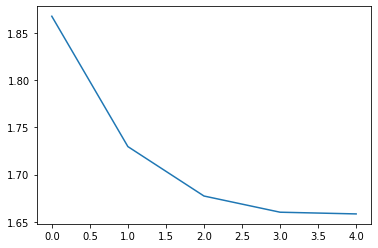

In [ ]:
plt.plot(val_loss_array)

In [ ]:
val_loss_array

[1.8673591914139396,
 1.729536161648007,
 1.6772611122431718,
 1.6601445956492986,
 1.658339613065945]

In [ ]:
# # Loading the best validation accuracy score weights
# encoder.load_weights("/content/drive/MyDrive/COCO/parth/assets/encoder.h5")
# decoder.load_weights("/content/drive/MyDrive/COCO/parth/assets/decder.h5")

In [ ]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tok = pickle.load(handle)

In [ ]:
def caption_image(path):
  image = load_img(path)#/255.0

  encodings = encoder.predict(tf.reshape(image,(1,img_dimension,img_dimension,3)))

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    
    texts.append(tok.index_word.get(idx))
    
    if idx == tok.word_index['<eos>']:
      break
    
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  #print(' '.join(texts))
  predictions = ' '.join(texts)
  plt.imshow(image/255.0)
  plt.axis("off")

  return predictions

'<sos> laptop computer sitting on top of desk <eos>'

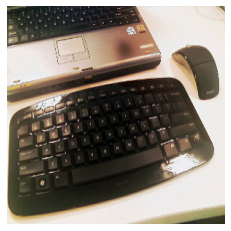

In [ ]:
caption_image(img_name_vector_test[121])

In [ ]:
for i,j in zip(img_name_vector_val, caption_val):
    print(i)
    print(j)
    pred = caption_image(i)
    break




100
200
300
400
500
600
700
800
900
1000
1100
HERE


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)




BLEU-1: 0.018108
BLEU-2: 0.134567
BLEU-3: 0.300167
BLEU-4: 0.366834


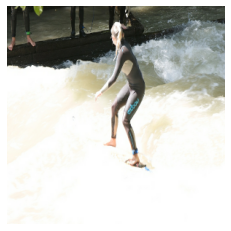

In [ ]:
def evaluate_model(encoder,decoder, img_name_vector_val2, caption_val2, log=False):
    actual, predicted = list(), list()
    # step over the whole set
    i=0
    counter = 0
    for key, desc_list in zip(img_name_vector_val2, caption_val2):
        # generate description
        i+=1
        #progressBar(i, len(caption_val), bar_length=20,job='Evaluating')
        pred = caption_image(key)
        # store actual and predicted
        references = desc_list.split()
        actual.append(references)
        predicted.append(pred.split())
        counter = counter+1
        if counter%100 == 0:
            print(counter) 
    # calculate BLEU score
    print("HERE")
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1, b2, b3, b4]
b1, b2, b3, b4 = evaluate_model(encoder,decoder, img_name_vector_test2,caption_test2)



100
200
300
400
500
600
700
800
900
1000
1100
HERE


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)




BLEU-1: 0.018108
BLEU-4: 0.366834


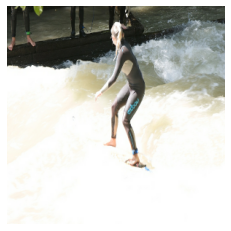

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(encoder,decoder, img_name_vector_val2, caption_val2, log=False):
    actual, predicted = list(), list()
    # step over the whole set
    i=0
    counter = 0
    for key, desc_list in zip(img_name_vector_val2, caption_val2):
        # generate description
        i+=1
        #progressBar(i, len(caption_val), bar_length=20,job='Evaluating')
        pred = caption_image(key)
        # store actual and predicted
        references = desc_list.split()
        actual.append(references)
        predicted.append(pred.split())
        counter = counter+1
        if counter%100 == 0:
            print(counter)
           
    # calculate BLEU score
    print("HERE")
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-4: %f' % b4)
    return [b1, b4]

b1,  b4 = evaluate_model(encoder,decoder, img_name_vector_test2, caption_test2)

In [ ]:
a = ['<sos>', 'kitchen', 'is', 'kosher', 'and', 'has', 'dual', 'black', 'appliances', '<eos>']
b = ['<sos>', 'kitchen', 'is', 'kosher', 'and', 'has', 'dual', 'black', 'appliances', '<eos>']

b1 = corpus_bleu(a, b, weights=(0.25, 0.25, 0.25, 0.25))
print(b1)

In [ ]:
print(len(img_name_vector_train))

In [ ]:
print(len(img_name_vector_val))

In [ ]:
print(len(caption_val))

'<sos> bus driving down street next to bus <eos>'

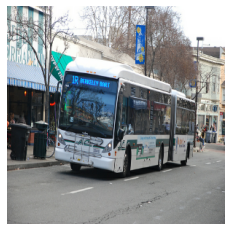

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/1.jpg")

'<sos> two elephants are walking through tall grass <eos>'

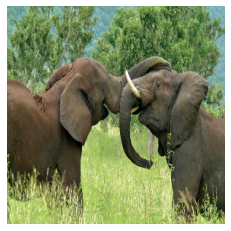

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/2.jpg")

'<sos> clock tower on top of building <eos>'

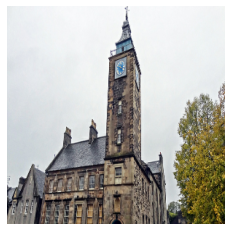

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/3.jpg")

'<sos> man sitting on boat in water <eos>'

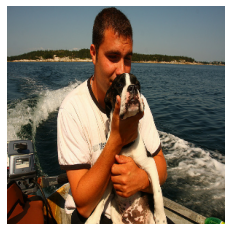

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/4.jpg")

'<sos> bowl of fruit with bowl of fruit <eos>'

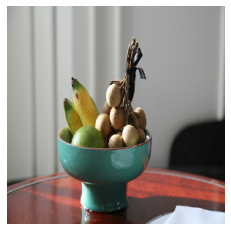

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/5.jpg")

'<sos> a close up of person holding bunch of bananas <eos>'

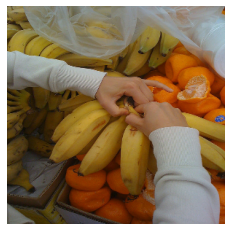

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/6.jpg")

'<sos> stove with pot on stove and oven <eos>'

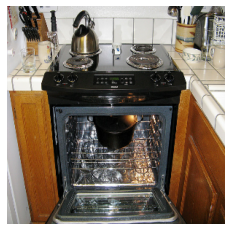

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/7.jpg")

'<sos> giraffe standing in dirt near tree <eos>'

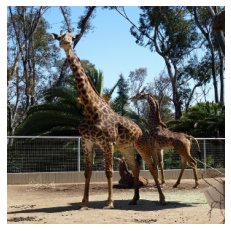

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/8.jpg")

'<sos> woman is standing on sidewalk with her hand on her phone <eos>'

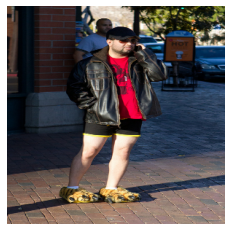

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/9.jpg")

'<sos> giraffe standing in grass next to fence <eos>'

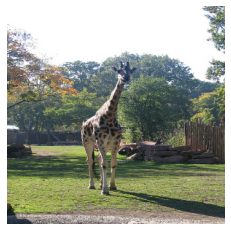

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/10.jpg")

'<sos> a couple of cows are standing in field <eos>'

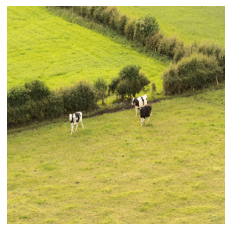

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/11.jpg")

'<sos> man in suit and tie is sitting on table <eos>'

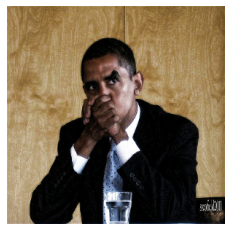

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/12.jpg")

'<sos> woman sitting on ground with her dog <eos>'

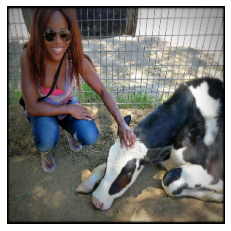

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/13.jpg")

'<sos> small bathroom with toilet and sink <eos>'

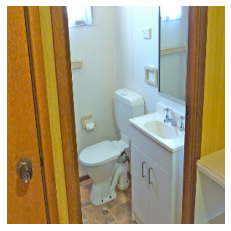

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/15.jpg")

'<sos> person is riding snowboard down side of snow covered slope <eos>'

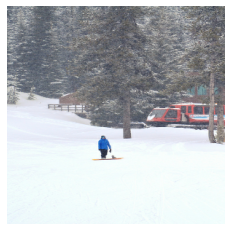

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/16.jpg")

'<sos> large truck is parked on side of road <eos>'

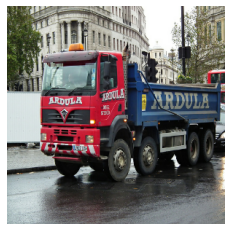

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/17.jpg")

'<sos> airplane is taking off from airport <eos>'

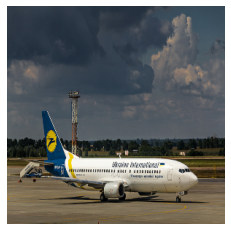

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/18.jpg")

In [ ]:
from keras.models import Model
# Loading the best validation accuracy score weights
encoder2 = keras.models.load_model("/content/drive/MyDrive/COCO/parth/assets/encoder.h5")
decoder2 = keras.models.load_model("/content/drive/MyDrive/COCO/parth/assets/decoder.h5")

In [ ]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tok = pickle.load(handle)

In [ ]:
def caption_image(path):
  image = load_img(path)#/255.0

  encodings = encoder2.predict(tf.reshape(image,(1,img_dimension,img_dimension,3)))

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder2.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    
    texts.append(tok.index_word.get(idx))
    
    if idx == tok.word_index['<eos>']:
      break
    
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  #print(' '.join(texts))
  predictions = ' '.join(texts)
  plt.imshow(image/255.0)
  plt.axis("off")

  return predictions

'<sos> airplane is taking off from airport <eos>'

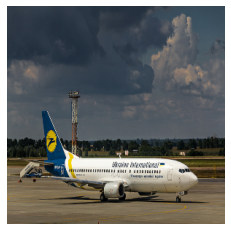

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/18.jpg")

'<sos> large truck is parked on side of road <eos>'

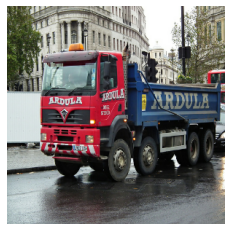

In [ ]:
caption_image("/content/drive/MyDrive/COCO/DEMO PICS/17.jpg")